In [1]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [2]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.1.0 @ https://github.com/MedMNIST/MedMNIST/


In [3]:
data_flag = 'pathmnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [4]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
train_dataset = DataClass(split='val', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /home/ps4364/.medmnist/pathmnist.npz
Using downloaded and verified file: /home/ps4364/.medmnist/pathmnist.npz
Using downloaded and verified file: /home/ps4364/.medmnist/pathmnist.npz


In [5]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset PathMNIST (pathmnist)
    Number of datapoints: 89996
    Root location: /home/ps4364/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K int

In [17]:
label_num2str={'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}

In [21]:
label_str2num={}
for i in label_num2str:
    label_str2num[label_num2str[i]]=i

In [22]:
label_str2num

{'adipose': '0',
 'background': '1',
 'debris': '2',
 'lymphocytes': '3',
 'mucus': '4',
 'smooth muscle': '5',
 'normal colon mucosa': '6',
 'cancer-associated stroma': '7',
 'colorectal adenocarcinoma epithelium': '8'}

/ext3/miniconda3/lib/python3.9/site-packages/medmnist/utils.py:25: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


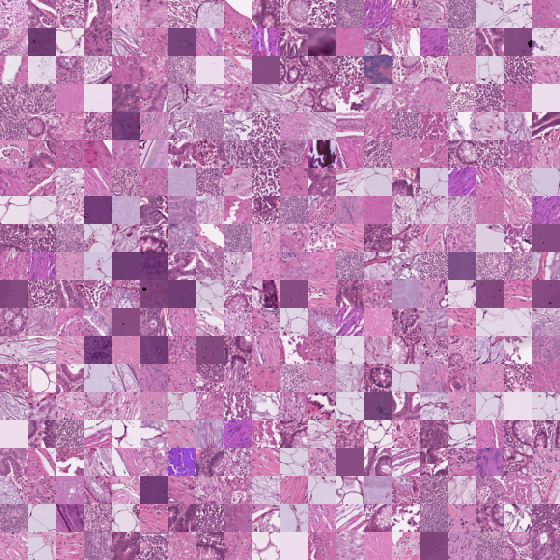

In [6]:
train_dataset.montage(length=20)

In [7]:
import os
import numpy as np
import pytorch_lightning as pl
import torch
import pandas as pd
import timm
import torch.nn as nn
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import KFold
from torchvision import transforms as tsfm
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning import seed_everything
from torchcontrib.optim import SWA
from torchmetrics import Metric


In [12]:
dist={}
for _,i in train_dataset:
    if i[0] in dist:
        dist[i[0]]+=1
    else:
        dist[i[0]]=1

In [13]:
dist

{0: 9366,
 4: 8006,
 7: 9401,
 5: 12182,
 8: 12885,
 3: 10401,
 2: 10360,
 1: 9509,
 6: 7886}

In [27]:
from collections import OrderedDict
dist = OrderedDict(sorted(dist.items()))
dist=dict(dist)

In [28]:
dist

{0: 9366,
 1: 9509,
 2: 10360,
 3: 10401,
 4: 8006,
 5: 12182,
 6: 7886,
 7: 9401,
 8: 12885}

We rearranged our distribution dictionary, so that when we normailse it retains its distribution to label mapping.

In [30]:
def normalize(arr, t_min, t_max):
    norm_arr = []
    diff = t_max - t_min
    diff_arr = max(arr) - min(arr)
    for i in arr:
        temp = (((i - min(arr))*diff)/diff_arr) + t_min
        norm_arr.append(temp)
    return norm_arr
  
# assign array and range
array_1d = dist.values()
range_to_normalize = (0.2, 1)
normalized_array_1d = normalize(
    array_1d, range_to_normalize[0], 
  range_to_normalize[1])
  
# display original and normalized array
print("Original Array = ", array_1d)
print("Normalized Array = ", normalized_array_1d)

Original Array =  dict_values([9366, 9509, 10360, 10401, 8006, 12182, 7886, 9401, 12885])
Normalized Array =  [0.4368473694738948, 0.4597319463892779, 0.5959191838367675, 0.6024804960992198, 0.21920384076815363, 0.8874974994999001, 0.2, 0.4424484896979396, 1.0]
